# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [7]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import sys
import json
import re
import glob

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import gc
from sklearn.preprocessing import LabelBinarizer

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.diffusion_model2 import DiffusionModel, CustomCallback

In [8]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-04 19:49:09.184938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 19:49:09.188678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 19:49:09.188796: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 16
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 128
EPOCHS = int(config_hp["epochs"])
T = 200
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-04 19:51:37.440330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 19:51:37.440469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 19:51:37.440530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (128, 16, 16, 3) => batch_size: 128, height: 16, width: 16, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


2024-04-04 19:52:00.749026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


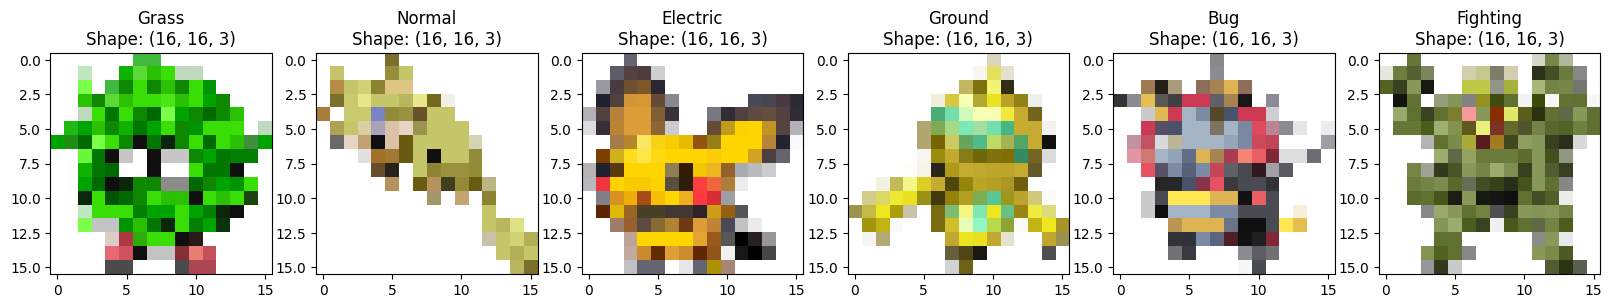

2024-04-04 19:52:01.249037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 16, 16, 3)
(32, 18)


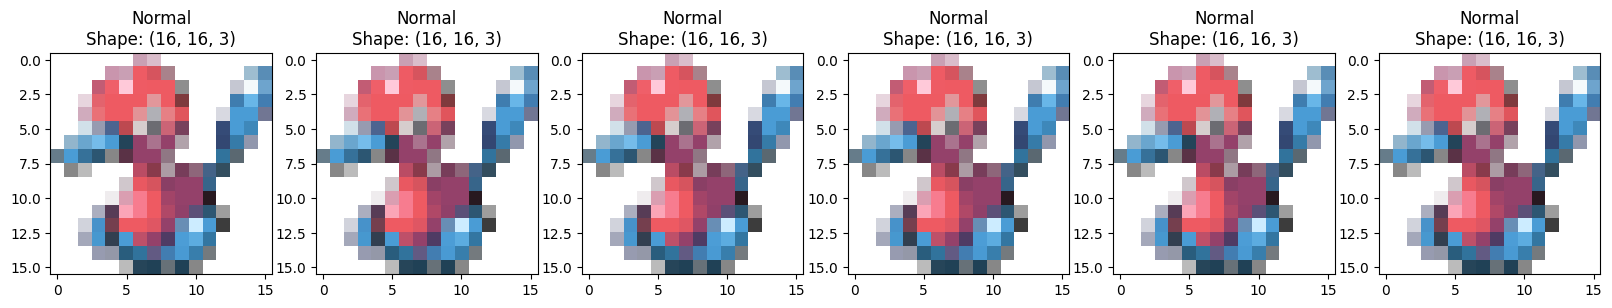

2024-04-04 19:54:14.794375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-04 19:54:14.795533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
# get only one image of the dataset
dataset_example = poke_dataset.take(1)

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(32).batch(32)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    visualize.plot_images_batch(dataset_tf=dataset_example)

In [ ]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)

In [34]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

In [35]:
model.fit(poke_dataset, epochs=EPOCHS)

Epoch 1/100


I0000 00:00:1712260488.332175   13664 service.cc:145] XLA service 0x7523ac0024d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712260488.332225   13664 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-04 19:54:48.490875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-04 19:54:49.186732: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1712260490.728493   15813 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2632', 52 bytes spill stores, 52 bytes spill loads

I0000 00:00:1712260490.780550   15811 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5322', 156 bytes spill stores, 156 bytes spill load

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.8791

I0000 00:00:1712260497.049083   13664 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.4398
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2916
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2656
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2481
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2325
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2224
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2159
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2117
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2074
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2039
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2018
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1999
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1981
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1966
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1957


Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.36it/s]


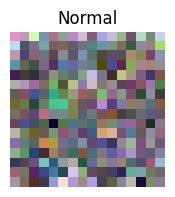

In [38]:
model.plot_samples(1, "Normal")

## Train Diffusion Model

### Training

In [55]:
# Algorithm 1: Training
# =====================================================================
def training(
    model: tf.keras.models.Model,
    dataset: tf.data.Dataset,
    optimizer: tf.keras.optimizers.Optimizer,
    loss_fn: tf.keras.losses.Loss,
    total_epochs: int = 10,
    scheduler: str = "cosine",
    T: int = 100,
) -> None:
    """
    Performs the training loop.

    :param model: The model to train.
    :param dataset: The training dataset.
    :param optimizer: The optimizer to use.
    :param loss_fn: The loss function to use.
    :param total_epochs: The number of epochs to train for.
    :param scheduler: The type of schedule to use. Options are "linear" or "cosine".
    :param T: The number of timesteps to sample for.
    :return: None
    """

    # Get scheduler values
    beta = beta_scheduler(scheduler, T, beta_start, beta_end)  # Get beta
    alpha = 1.0 - beta  # Get alpha
    alpha_cumprod = np.cumprod(alpha)  # Get alpha cumulative product

    for epoch in trange(
        prev_epoch,
        total_epochs,
        desc=f"Training",
        total=total_epochs - prev_epoch,
        leave=True,
    ):  # 1: repeat (iterations through the epochs)
        for step, input_data in tqdm(
            enumerate(dataset),
            desc=f"Epoch {epoch+1}/{total_epochs}",
            total=len(dataset),
            leave=True,
        ):  # 1: repeat (iterations through the batches)
            # Generate a single timestep for one entire batch
            t = np.random.randint(0, T)
            normalized_t = np.full(
                (input_data.shape[0], 1), t / T, dtype=np.float32
            )  # 3: t ~ U(0, T)

            # Get the target noise
            noised_data = forward_diffusion(input_data, t, scheduler)  # 2: x_0 ~ q(x_0)
            target_noise = noised_data - input_data * np.sqrt(
                alpha_cumprod[t]
            )  # 4: eps_t ~ N(0, I)

            # 5: Take a gradient descent step on
            with tf.GradientTape() as tape:
                predicted_noise = model(
                    [noised_data, normalized_t], training=True
                )  # eps_theta -> model(x_t, t/T)
                loss = loss_fn(
                    target_noise, predicted_noise
                )  # gradient of the loss (MSE(eps_t, eps_theta))
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # if step % 2 == 0:
            #     plt.subplot(1,3,1)
            #     plt.imshow(input_data[0])
            #     plt.title('input')
            #     plt.subplot(1,3,2)
            #     plt.imshow(noised_data[0])
            #     plt.title('noised')
            #     plt.subplot(1,3,3)
            #     plt.imshow(target_noise[0])
            #     plt.title('target')
            #     plt.show()

            # f, axis = plt.subplots(1, 2, figsize=(10, 5))
            # axis[0].imshow(target_noise[0]*0.5+0.5)
            # axis[0].set_title('target noise')
            # axis[1].imshow(predicted_noise[0]*0.5+0.5)
            # axis[1].set_title('predicted noise')
            # plt.show()

        print(f"EPOCH {epoch+1} LOSS: {loss.numpy():.4f} \n{'='*69}")

        # # Save the model and it's weights at the end of every 20 epochs
        # if (epoch+1) % 20 == 0:
        #     print(f"\tSaving model and its _weights in epoch {epoch+1}")
        #     model.save(f'{folder_epoch}/diffusion_{scheduler}_{epoch+1}.h5')
        #     model.save_weights(f'{folder_epoch}/weights{scheduler}_{epoch+1}.h5')

        # Sample and plot every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("\tSampling images...")
            plot_samples(model, num_samples=3, scheduler=scheduler, T=T)